In [1]:
import os

In [2]:
computation = 'cloud'

In [3]:
if computation == 'cloud' :
  from google.colab import drive
  drive.mount('/content/drive')
  data_path = '/content/drive/MyDrive/uco_fraud_detector/data/transaction_fraud'
  model_save_path = '/content/drive/MyDrive/uco_fraud_detector/models'
  customer_fr_path = '/content/drive/MyDrive/uco_fraud_detector/models/customer_fr_database'
  merchant_fr_path = '/content/drive/MyDrive/uco_fraud_detector/models/merchant_fr_database'
  globalmodel_path = '/content/drive/MyDrive/uco_fraud_detector/models/globalmodel'
else :
  data_path = '../data/transaction_fraud'
  model_save_path = '../models'
  customer_fr_path = '../models/customer_fr_database'
  merchant_fr_path = '../models/merchant_fr_database'
  globalmodel_path = '../models/globalmodel'

print("searching for data path" , "found" if os.path.exists(data_path) else "not found")
print(os.listdir(data_path))

Mounted at /content/drive
searching for data path found
['bs140513_032310.csv', 'bsNET140513_032310.csv']


In [4]:
data_path = os.path.join(data_path, 'bs140513_032310.csv')

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from collections import defaultdict
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder
import pickle
from tensorflow.keras.layers import Input, Dense, Embedding, MultiHeadAttention, LayerNormalization, Dropout , Lambda , GlobalAveragePooling1D , Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras import mixed_precision

In [6]:
np.random.seed(21)
tf.random.set_seed(21)
mixed_precision.set_global_policy('mixed_float16')

### Data Preprocessing

In [7]:
data_preprocess_path = '/content/drive/MyDrive/uco_fraud_detector/data/data_preprocess'
with open(data_preprocess_path, 'rb') as f :
  data_preprocess = pickle.load(f)

In [8]:
df = pd.read_csv(data_path)
df = df.replace("'" , "" , regex=True)
df = df.drop(['zipcodeOri' , 'zipMerchant'] , axis = 1)
df['account_frequency'] = df['customer'].apply(lambda x: data_preprocess['customer_frequency_rating_encoder'][x])
df['merchant_frequency'] = df['merchant'].apply(lambda x: data_preprocess['merchant_frequency_rating_encoder'][x])
df = df.rename(columns={'customer': 'account_id', 'merchant': 'merchant_id', 'step': 'time_delta'})
for c in data_preprocess['CATEGORICAL_COLS'] :
  df[c] = data_preprocess[c + '_label_encoder'].transform(df[c])
df[data_preprocess['NUMERICAL_COLS']] = data_preprocess['numerical_scaler'].transform(df[data_preprocess['NUMERICAL_COLS']])
valid_data = df[df['fraud'] == 0].copy()

valid_data.head()

,time_delta,account_id,age,gender,merchant_id,category,amount,fraud,account_frequency,merchant_frequency
0,-1.860532,C1093826151,4,2,30,12,-0.299276,0,0.340420,-0.182271
1,-1.860532,C352968107,2,2,30,12,0.016067,0,0.410385,-0.182271
2,-1.860532,C2054744914,4,1,18,12,-0.098742,0,-3.227803,0.765246
3,-1.860532,C1760612790,3,2,30,12,-0.185275,0,0.480350,-0.182271
4,-1.860532,C757503768,5,2,30,12,-0.019480,0,-0.429197,-0.182271


In [9]:
# Group transactions by account_id and filter accounts with >=10 transactions
account_groups = valid_data.groupby('account_id')
account_sequences = defaultdict(list)
for account_id, group in account_groups:
        group = group.sort_values('time_delta')  # Sort by time_delta
        account_sequences[account_id] = group[['time_delta', 'account_frequency',
                                              'merchant_frequency', 'amount',
                                              'age', 'gender', 'category',
                                              'merchant_id']].values

# Split accounts into train (80%) and validation (20%) sets
# gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=21)
# train_idx, val_idx = next(gss.split(valid_data, groups=valid_data['account_id']))


# train_accounts = [aid for aid in valid_data.iloc[train_idx]['account_id'].unique() if aid in account_sequences]
# val_accounts = [aid for aid in valid_data.iloc[val_idx]['account_id'].unique() if aid in account_sequences]
train_accounts = valid_data['account_id'].unique()

train_sequences = {aid: account_sequences[aid] for aid in train_accounts}
# val_sequences = {aid: account_sequences[aid] for aid in val_accounts}
account_ids = np.array(list(account_sequences.keys()))

print(f"Total accounts with transactions: {len(account_sequences)}")
print(f"Train accounts: {len(train_sequences)}")
# print(f"Validation accounts: {len(val_sequences)}")


Total accounts with transactions: 4112
Train accounts: 4112


In [10]:
categorical_cols = ['age', 'gender', 'category', 'merchant_id']
vocab_sizes = {col: int(valid_data[col].max()) + 1 for col in categorical_cols}
print("Vocabulary sizes:", vocab_sizes)

Vocabulary sizes: {'age': 8, 'gender': 4, 'category': 15, 'merchant_id': 50}


In [11]:
def prepare_sequences(sequences):
    processed = {}
    for account_id, seq in sequences.items():
        # print(f"Processing account {account_id} with {len(seq)} transactions")
        processed[account_id] = {
            'numerical': seq[:, :4].astype(np.float32),  # time_delta, account_frequency, merchant_frequency, amount
            'age': seq[:, 4].astype(np.int32),
            'gender': seq[:, 5].astype(np.int32),
            'category': seq[:, 6].astype(np.int32),
            'merchant_id': seq[:, 7].astype(np.int32)
        }
    return processed

train_sequences_processed = prepare_sequences(train_sequences)
# val_sequences_processed = prepare_sequences(val_sequences)

## Transformer embedding

### Transformer Encoder

In [ ]:
embed_dim = 127  # 4 numerical + 6 age + 2 gender + 15 category + 100 merchant_id
num_heads = 8
ff_dim = 256
dropout_rate = 0.1
n_dims = 64
max_seq_len = 200  # Cap maximum sequence length

# Input layers
numerical_input = Input(shape=(None, 4), name='numerical')
age_input = Input(shape=(None,), dtype=tf.int32, name='age')
gender_input = Input(shape=(None,), dtype=tf.int32, name='gender')
category_input = Input(shape=(None,), dtype=tf.int32, name='category')
merchant_input = Input(shape=(None,), dtype=tf.int32, name='merchant_id')

# Create padding mask
mask_input = Lambda(lambda x: tf.cast(tf.reduce_any(x != 0, axis=-1), tf.float32)[:, :, tf.newaxis])(numerical_input)

# Embedding layers
age_embed = Embedding(input_dim=vocab_sizes['age'], output_dim=6)(age_input)
gender_embed = Embedding(input_dim=vocab_sizes['gender'], output_dim=2)(gender_input)
category_embed = Embedding(input_dim=vocab_sizes['category'], output_dim=15)(category_input)
merchant_embed = Embedding(input_dim=vocab_sizes['merchant_id'], output_dim=100)(merchant_input)

# Concatenate embeddings
total_embed = Concatenate(axis=-1)([numerical_input, age_embed, gender_embed, category_embed, merchant_embed])

# Transformer block
x = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim//num_heads)(total_embed, total_embed, total_embed, attention_mask=mask_input)
x = Dropout(dropout_rate)(x)
x = LayerNormalization(epsilon=1e-6)(x + total_embed)
ff = Dense(ff_dim, activation='relu')(x)
ff = Dropout(dropout_rate)(ff)
ff = Dense(embed_dim)(ff)
x = LayerNormalization(epsilon=1e-6)(x + ff)

# Split for embedding and reconstruction
# For embedding: global average pooling
embedding_x = GlobalAveragePooling1D()(x)
embedding_output = Dense(n_dims, activation=None, name='embedding', dtype='float32')(embedding_x)

# For reconstruction: keep sequence dimension
recon_numerical = Dense(4, activation=None, name='recon_numerical')(x)
recon_age = Dense(vocab_sizes['age'], activation='softmax', name='recon_age')(x)
recon_gender = Dense(vocab_sizes['gender'], activation='softmax', name='recon_gender')(x)
recon_category = Dense(vocab_sizes['category'], activation='softmax', name='recon_category')(x)
recon_merchant = Dense(vocab_sizes['merchant_id'], activation='softmax', name='recon_merchant')(x)

# Models
autoencoder_model = Model(
    inputs=[numerical_input, age_input, gender_input, category_input, merchant_input],
    outputs=[recon_numerical, recon_age, recon_gender, recon_category, recon_merchant]
)
embedding_model = Model(
    inputs=[numerical_input, age_input, gender_input, category_input, merchant_input],
    outputs=embedding_output
)

# Compile autoencoder
autoencoder_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss={
        'recon_numerical': 'mse',
        'recon_age': 'sparse_categorical_crossentropy',
        'recon_gender': 'sparse_categorical_crossentropy',
        'recon_category': 'sparse_categorical_crossentropy',
        'recon_merchant': 'sparse_categorical_crossentropy'
    },
    loss_weights={
        'recon_numerical': 1.0,
        'recon_age': 0.2,
        'recon_gender': 0.2,
        'recon_category': 0.5,
        'recon_merchant': 0.5
    }
)

# Build model with fixed input shape
input_shapes = {
    'numerical': (None, max_seq_len, 4),
    'age': (None, max_seq_len),
    'gender': (None, max_seq_len),
    'category': (None, max_seq_len),
    'merchant': (None, max_seq_len)
}
autoencoder_model.build(input_shapes)
embedding_model.build(input_shapes)

In [ ]:
from keras.utils import plot_model
plot_model(autoencoder_model, to_file='auto_encoder_model.png', show_shapes=True, show_layer_names=True)
plot_model(embedding_model, to_file='embedding_model.png', show_shapes=True, show_layer_names=True)
print("file saved")

file saved


### training

In [ ]:
batch_size = 32
epochs = 100

def generate_batch(sequences, account_ids, batch_size, max_seq_len=200):
    num_batches = int(np.ceil(len(account_ids) / batch_size))
    for idx in range(num_batches):
        batch_ids = account_ids[idx * batch_size:(idx + 1) * batch_size]
        max_len = min(max(len(sequences[aid]['numerical']) for aid in batch_ids), max_seq_len)


        numerical = np.zeros((len(batch_ids), max_len, 4), dtype=np.float32)
        age = np.zeros((len(batch_ids), max_len), dtype=np.int32)
        gender = np.zeros((len(batch_ids), max_len), dtype=np.int32)
        category = np.zeros((len(batch_ids), max_len), dtype=np.int32)
        merchant = np.zeros((len(batch_ids), max_len), dtype=np.int32)

        for i, aid in enumerate(batch_ids):
            seq_len = min(len(sequences[aid]['numerical']), max_seq_len)
            numerical[i, :seq_len] = sequences[aid]['numerical'][:seq_len]
            age[i, :seq_len] = sequences[aid]['age'][:seq_len]
            gender[i, :seq_len] = sequences[aid]['gender'][:seq_len]
            category[i, :seq_len] = sequences[aid]['category'][:seq_len]
            merchant[i, :seq_len] = sequences[aid]['merchant_id'][:seq_len]

        yield {
            'numerical': numerical,
            'age': age,
            'gender': gender,
            'category': category,
            'merchant_id': merchant
        }, {
            'recon_numerical': numerical,
            'recon_age': age,
            'recon_gender': gender,
            'recon_category': category,
            'recon_merchant': merchant
        }

In [ ]:
train_ids = np.array(list(train_sequences_processed.keys()))
val_ids = np.array(list(val_sequences_processed.keys()))

prev_val_loss = float('inf')
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    # Train
    train_loss = 0.0  # Initialize as float
    for batch_inputs, batch_outputs in generate_batch(train_sequences_processed, train_ids, batch_size, 500):
        loss = autoencoder_model.train_on_batch(batch_inputs, batch_outputs)
        train_loss += loss[0]  # Use total weighted loss (first element)
    train_loss /= len(train_ids) // batch_size + 1

    # Validation
    val_loss = 0.0  # Initialize as float
    for batch_inputs, batch_outputs in generate_batch(val_sequences_processed, val_ids, batch_size, max_seq_len):
        val_loss += autoencoder_model.evaluate(batch_inputs, batch_outputs, verbose=0)[0]  # Use total weighted loss
    val_loss /= len(val_ids) // batch_size + 1

    print(f"Train loss: {train_loss:.4f}, Val loss: {val_loss:.4f}")

    # Early stopping
    if epoch > 2 and val_loss > prev_val_loss:
        print("Early stopping triggered")
        break
    prev_val_loss = val_loss

Epoch 1/100
Train loss: 5.9392, Val loss: 6.1607
Epoch 2/100
Train loss: 5.9386, Val loss: 6.1607
Epoch 3/100
Train loss: 5.9380, Val loss: 6.1607
Epoch 4/100
Train loss: 5.9399, Val loss: 6.1607
Epoch 5/100
Train loss: 5.9396, Val loss: 6.1607
Epoch 6/100
Train loss: 5.9381, Val loss: 6.1607
Epoch 7/100
Train loss: 5.9394, Val loss: 6.1607
Epoch 8/100


KeyboardInterrupt: 

### embedding

In [ ]:
embeddings = {}
for account_id in account_ids:
    seq = train_sequences_processed.get(account_id, val_sequences_processed.get(account_id))
    max_len = min(len(seq['numerical']), max_seq_len)
    numerical = np.zeros((1, max_len, 4), dtype=np.float32)
    age = np.zeros((1, max_len), dtype=np.int32)
    gender = np.zeros((1, max_len), dtype=np.int32)
    category = np.zeros((1, max_len), dtype=np.int32)
    merchant = np.zeros((1, max_len), dtype=np.int32)

    numerical[0, :max_len] = seq['numerical'][:max_len]
    age[0, :max_len] = seq['age'][:max_len]
    gender[0, :max_len] = seq['gender'][:max_len]
    category[0, :max_len] = seq['category'][:max_len]
    merchant[0, :max_len] = seq['merchant_id'][:max_len]

    embedding = embedding_model.predict(
        {
            'numerical': numerical,
            'age': age,
            'gender': gender,
            'category': category,
            'merchant_id': merchant
        },
        verbose=0
    )
    embeddings[account_id] = embedding[0]


In [ ]:
# Save embeddings and models
np.save('account_embeddings.npy', embeddings)
autoencoder_model.save('transformer_autoencoder.h5')
embedding_model.save('transformer_embedding.h5')

### dynamic update

In [ ]:

# Step 7: Dynamic Updates
def update_embedding(account_id, new_transaction, autoencoder_model, embedding_model, sequences_processed, max_seq_len=200):
    # Prepare new transaction
    numerical = new_transaction[:4][np.newaxis, :].astype(np.float32)
    age = np.array([new_transaction[4]], dtype=np.int32)
    gender = np.array([new_transaction[5]], dtype=np.int32)
    category = np.array([new_transaction[6]], dtype=np.int32)
    merchant = np.array([new_transaction[7]], dtype=np.int32)

    # Append to sequence
    seq = sequences_processed.get(account_id)
    if seq is None:
        seq = {
            'numerical': numerical,
            'age': age,
            'gender': gender,
            'category': category,
            'merchant_id': merchant
        }
    else:
        seq['numerical'] = np.vstack([seq['numerical'], numerical])
        seq['age'] = np.append(seq['age'], age)
        seq['gender'] = np.append(seq['gender'], gender)
        seq['category'] = np.append(seq['category'], category)
        seq['merchant_id'] = np.append(seq['merchant_id'], merchant)

    # Check transaction count
    transaction_count = len(seq['numerical'])
    if transaction_count < 10:
        print(f"Skipping embedding update for account {account_id}: {transaction_count} transactions (<10)")
        return None

    sequences_processed[account_id] = seq

    # Prepare input with capped sequence length
    max_len = min(len(seq['numerical']), max_seq_len)
    numerical_input = np.zeros((1, max_len, 4), dtype=np.float32)
    age_input = np.zeros((1, max_len), dtype=np.int32)
    gender_input = np.zeros((1, max_len), dtype=np.int32)
    category_input = np.zeros((1, max_len), dtype=np.int32)
    merchant_input = np.zeros((1, max_len), dtype=np.int32)

    numerical_input[0, :max_len] = seq['numerical'][:max_len]
    age_input[0, :max_len] = seq['age'][:max_len]
    gender_input[0, :max_len] = seq['gender'][:max_len]
    category_input[0, :max_len] = seq['category'][:max_len]
    merchant_input[0, :max_len] = seq['merchant_id'][:max_len]

    # Fine-tune autoencoder
    autoencoder_model.train_on_batch(
        {
            'numerical': numerical_input,
            'age': age_input,
            'gender': gender_input,
            'category': category_input,
            'merchant_id': merchant_input
        },
        {
            'recon_numerical': numerical_input,
            'recon_age': age_input,
            'recon_gender': gender_input,
            'recon_category': category_input,
            'recon_merchant': merchant_input
        }
    )

    # Extract updated embedding
    embedding = embedding_model.predict(
        {
            'numerical': numerical_input,
            'age': age_input,
            'gender': gender_input,
            'category': category_input,
            'merchant': merchant_input
        },
        verbose=0
    )
    print(f"Updated embedding for account {account_id}: {transaction_count} transactions")
    return embedding[0]

In [ ]:
# Example: Update embedding
new_transaction = valid_data.iloc[0][['time_delta', 'account_frequency', 'merchant_frequency',
                                      'amount', 'age', 'gender', 'category', 'merchant_id']].values
account_id = valid_data.iloc[0]['account_id']
updated_embedding = update_embedding(account_id, new_transaction, autoencoder_model, embedding_model, train_sequences_processed, max_seq_len)
if updated_embedding is not None:
    embeddings[account_id] = updated_embedding


In [ ]:
# Save updated embeddings
np.save('account_embeddings_updated.npy', embeddings)

## Statistical Embedding

In [12]:
def generate_statistical_embedding(seq, vocab_sizes):
    embedding = []

    # Numerical features: mean, std, min, max for time_delta, account_frequency, merchant_frequency, amount
    numerical = seq['numerical']  # Shape: [seq_len, 4]
    if len(numerical) == 0:
        numerical_stats = np.zeros(16, dtype=np.float32)
    else:
        mean = np.mean(numerical, axis=0)  # Shape: [4]
        std = np.std(numerical, axis=0)   # Shape: [4]
        min_vals = np.min(numerical, axis=0)  # Shape: [4]
        max_vals = np.max(numerical, axis=0)  # Shape: [4]
        numerical_stats = np.concatenate([mean, std, min_vals, max_vals])  # Shape: [16]

    embedding.extend(numerical_stats)

    # Categorical features: normalized frequency histograms
    # Age: 8 possible values
    age_counts = np.bincount(seq['age'], minlength=vocab_sizes['age'])
    age_freq = age_counts / (np.sum(age_counts) + 1e-8)  # Normalize, avoid division by zero
    embedding.extend(age_freq)

    # Gender: 4 possible values
    gender_counts = np.bincount(seq['gender'], minlength=vocab_sizes['gender'])
    gender_freq = gender_counts / (np.sum(gender_counts) + 1e-8)
    embedding.extend(gender_freq)

    # Category: 15 possible values
    category_counts = np.bincount(seq['category'], minlength=vocab_sizes['category'])
    category_freq = category_counts / (np.sum(category_counts) + 1e-8)
    embedding.extend(category_freq)

    # Merchant_id: 50 possible values, select top 21 for 21D
    merchant_counts = np.bincount(seq['merchant_id'], minlength=vocab_sizes['merchant_id'])
    # Get top 21 merchant indices by frequency
    top_merchants = np.argsort(-merchant_counts)[:21]  # Sort descending, take top 21
    merchant_freq = np.zeros(21, dtype=np.float32)
    for i, idx in enumerate(top_merchants):
        merchant_freq[i] = merchant_counts[idx] / (np.sum(merchant_counts) + 1e-8)
    embedding.extend(merchant_freq)

    # Ensure 64D embedding
    embedding = np.array(embedding, dtype=np.float32)
    assert len(embedding) == 64, f"Embedding size is {len(embedding)}, expected 64"
    return embedding


In [13]:
embeddings = {}
for account_id in account_ids:
    seq = train_sequences_processed.get(account_id)
    embeddings[account_id] = generate_statistical_embedding(seq, vocab_sizes)


In [15]:
import pickle
embedding_save_path = '/content/drive/MyDrive/uco_fraud_detector/data/account_embedding'
with open(embedding_save_path, 'wb') as f:
    pickle.dump(embeddings, f)

In [14]:
len(embeddings.keys())

4112

### dynamicupdate

In [ ]:
def update_embedding(account_id, new_transaction, sequences_processed, vocab_sizes, max_seq_len=200):
    # Prepare new transaction
    numerical = new_transaction[:4][np.newaxis, :].astype(np.float32)
    age = np.array([new_transaction[4]], dtype=np.int32)
    gender = np.array([new_transaction[5]], dtype=np.int32)
    category = np.array([new_transaction[6]], dtype=np.int32)
    merchant = np.array([new_transaction[7]], dtype=np.int32)

    # Append to sequence
    seq = sequences_processed.get(account_id)
    if seq is None:
        seq = {
            'numerical': numerical,
            'age': age,
            'gender': gender,
            'category': category,
            'merchant_id': merchant
        }
    else:
        seq['numerical'] = np.vstack([seq['numerical'], numerical])
        seq['age'] = np.append(seq['age'], age)
        seq['gender'] = np.append(seq['gender'], gender)
        seq['category'] = np.append(seq['category'], category)
        seq['merchant_id'] = np.append(seq['merchant_id'], merchant)

    # Cap sequence length
    if len(seq['numerical']) > max_seq_len:
        seq['numerical'] = seq['numerical'][-max_seq_len:]
        seq['age'] = seq['age'][-max_seq_len:]
        seq['gender'] = seq['gender'][-max_seq_len:]
        seq['category'] = seq['category'][-max_seq_len:]
        seq['merchant_id'] = seq['merchant_id'][-max_seq_len:]

    # Check transaction count
    transaction_count = len(seq['numerical'])
    # if transaction_count < 10:
    #     print(f"Skipping embedding update for account {account_id}: {transaction_count} transactions (<10)")
    #     return None

    sequences_processed[account_id] = seq

    # Generate updated embedding
    embedding = generate_statistical_embedding(seq, vocab_sizes)
    print(f"Updated embedding for account {account_id}: {transaction_count} transactions")
    return embedding


In [ ]:
new_transaction = valid_data.iloc[9][['time_delta', 'account_frequency', 'merchant_frequency',
                                      'amount', 'age', 'gender', 'category', 'merchant_id']].values
account_id = valid_data.iloc[0]['account_id']
updated_embedding = update_embedding(account_id, new_transaction, train_sequences_processed, vocab_sizes, max_seq_len=200)
if updated_embedding is not None:
    embeddings[account_id] = updated_embedding

Updated embedding for account C1093826151: 2 transactions


## visualizing

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import os

In [ ]:
# embeddings = np.load('account_embeddings.npy', allow_pickle=True).item()
account_ids = list(embeddings.keys())
embedding_matrix = np.array([embeddings[aid] for aid in account_ids])

In [ ]:
avg_amount = valid_data.groupby('account_id')['amount'].mean().reindex(account_ids).values

In [ ]:
pca = PCA(n_components=3, random_state=21)
embeddings_3d_pca = pca.fit_transform(embedding_matrix)  # Shape: [4063, 3]
explained_variance = pca.explained_variance_ratio_.sum()
print(f"PCA explained variance ratio (3 components): {explained_variance:.4f}")

PCA explained variance ratio (3 components): 0.8743


In [ ]:
kmeans = KMeans(n_clusters=5, random_state=21)
cluster_labels = kmeans.fit_predict(embedding_matrix)

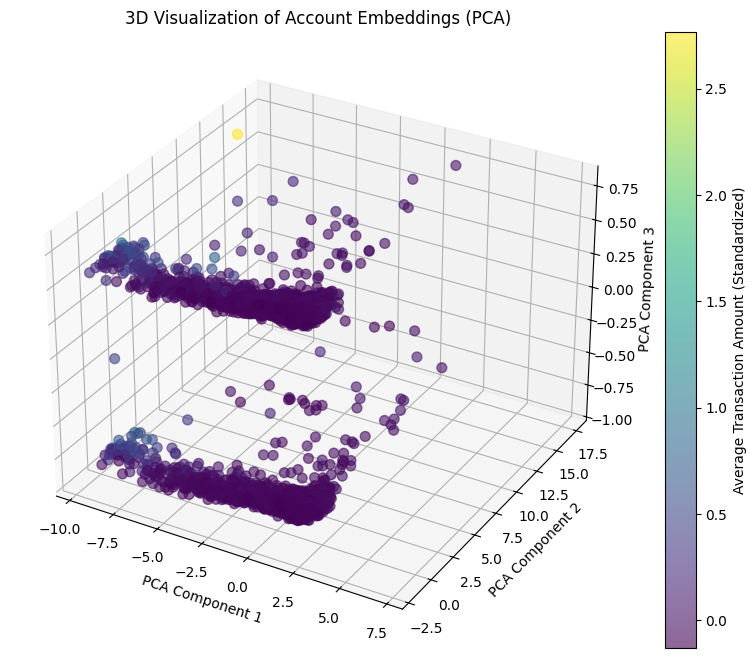

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    embeddings_3d_pca[:, 0],
    embeddings_3d_pca[:, 1],
    embeddings_3d_pca[:, 2],
    c=avg_amount,
    cmap='viridis',
    s=50,
    alpha=0.6
)

# Add colorbar
plt.colorbar(scatter, label='Average Transaction Amount (Standardized)')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
ax.set_title('3D Visualization of Account Embeddings (PCA)')
plt.savefig('embeddings_3d_pca_amount.png')
plt.show()


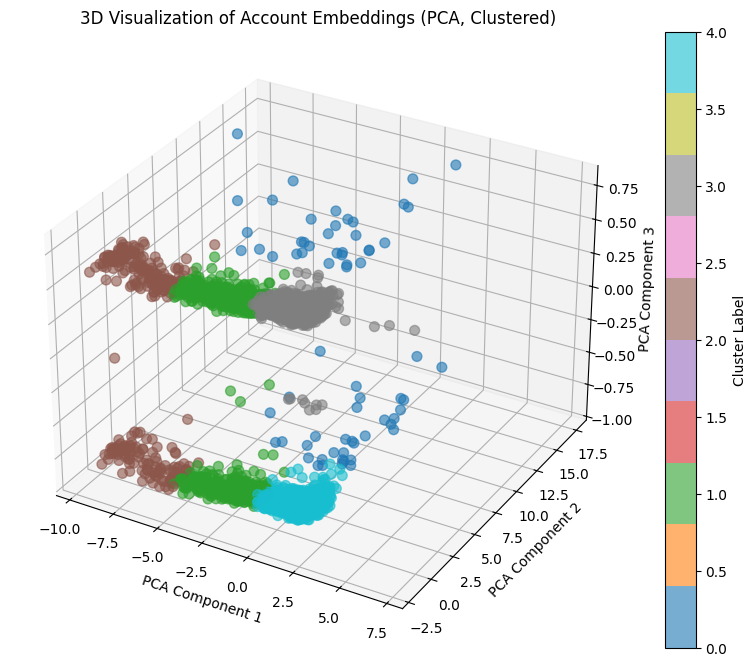

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    embeddings_3d_pca[:, 0],
    embeddings_3d_pca[:, 1],
    embeddings_3d_pca[:, 2],
    c=cluster_labels,
    cmap='tab10',
    s=50,
    alpha=0.6
)
plt.colorbar(scatter, label='Cluster Label')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
ax.set_title('3D Visualization of Account Embeddings (PCA, Clustered)')
plt.savefig('embeddings_3d_pca_clusters.png')
plt.show()


In [ ]:
tsne = TSNE(n_components=3, random_state=21, n_jobs=-1)
embeddings_3d_tsne = tsne.fit_transform(embedding_matrix)

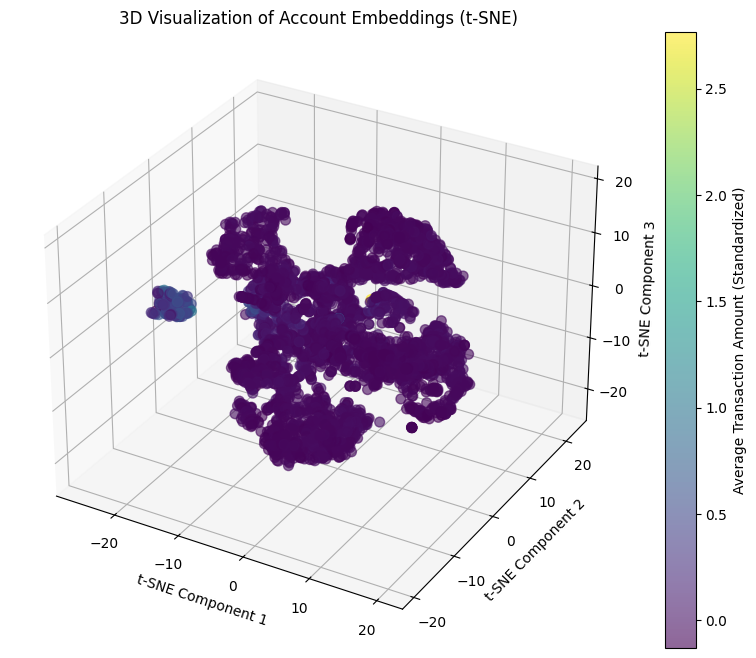

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    embeddings_3d_tsne[:, 0],
    embeddings_3d_tsne[:, 1],
    embeddings_3d_tsne[:, 2],
    c=avg_amount,
    cmap='viridis',
    s=50,
    alpha=0.6
)
plt.colorbar(scatter, label='Average Transaction Amount (Standardized)')
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_zlabel('t-SNE Component 3')
ax.set_title('3D Visualization of Account Embeddings (t-SNE)')
plt.savefig('embeddings_3d_tsne_amount.png')
plt.show()

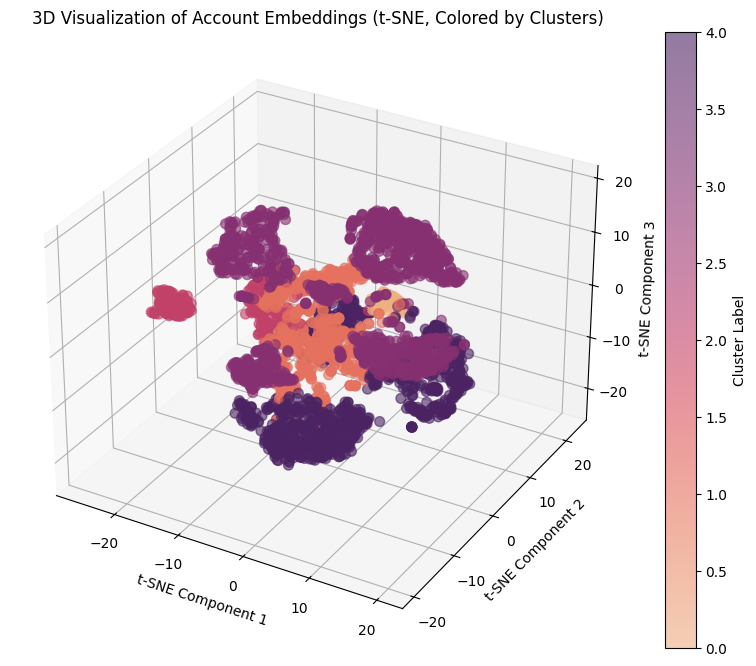

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    embeddings_3d_tsne[:, 0],
    embeddings_3d_tsne[:, 1],
    embeddings_3d_tsne[:, 2],
    c=cluster_labels,
    cmap='flare',
    s=50,
    alpha=0.6
)
plt.colorbar(scatter, label='Cluster Label')
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_zlabel('t-SNE Component 3')
ax.set_title('3D Visualization of Account Embeddings (t-SNE, Colored by Clusters)')
plt.savefig('embeddings_3d_tsne_clusters.png')
plt.show()